# Examine SRlite stability across overlapping scenes at pseudo-invariant calibration sites
### Create a time series of SR values at selected points

In [132]:
import geopandas
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Point
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from datetime import datetime
import os
import pyproj

!pip install mizani

import plotnine
from plotnine import * 
from mizani.breaks import date_breaks
from mizani.formatters import date_format

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib

import contextily as ctx
from contextily.tile import warp_img_transform, warp_tiles, _warper

Defaulting to user installation because normal site-packages is not writeable


Functions to generate random points

In [2]:
def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

def get_random_points_in_bounds(rio_dataset, n_points=100):
    '''Return a gdf of a set of n random points within a rasterio dataset's bounds
    https://www.matecdev.com/posts/random-points-in-polygon.html
    '''
    # Get crs for raster
    raster_proj = pyproj.Proj(rio_dataset.crs)
    
    # Create shapely polygon from raster bounds
    from shapely.geometry import box
    geom = box(*rio_dataset.bounds)
    gdf_poly = geopandas.GeoDataFrame(index=[rio_dataset.name], geometry=[geom], crs=rio_dataset.crs)
    gdf_poly['name'] = os.path.basename(rio_dataset.name)
    #print(gdf_poly)
    #ax=gdf_poly.plot()

    x,y = Random_Points_in_Bounds(geom, n_points)
    
    # Convert to lon,lat
    inProj = pyproj.Proj(rio_dataset.crs)
    outProj = pyproj.Proj(init='epsg:4326')
    lon, lat = pyproj.transform(inProj, outProj, x, y)
    
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df["lon"] = lon
    df["lat"] = lat
    df['geometry'] = df['points'].apply(Point)
    df['site'] = df.index + 1
    df['crs'] = raster_proj
    
    gdf_points = geopandas.GeoDataFrame(df, geometry='geometry', crs=rio_dataset.crs)
    #gdf_points.plot(ax=ax, color='red')
    
    return gdf_points, gdf_poly

Function to extract the raster values for points in the gdf

In [70]:
df_sr = get_ref_timeseries_table(gdf_random_points, f_list, batchname=BATCHNAME, DO_4BAND=False)

['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']


In [212]:
#band_names_list = ['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
def plot_timeseries(df, BANDSLIST = ["BAND_B","BAND_G","BAND_R","BAND_N"], YLIMS = (0.20,0.75), DO_NAMES = False):
    
    df.m = pd.melt(df, id_vars=["site","geometry","batchname","name","date","year",'sensor','lon','lat','type_ref'], value_vars=BANDSLIST)
    
    # Use dropna() to ensure all points in time are connected with a line
    p = (
        ggplot(df.m.dropna(), aes(x="date", y='value', color='variable', group='variable', linetype='sensor', shape="sensor"))
        + labs(title='Time-series at sites', y='Reflectance', x=None)
        + geom_point(size=2)
        + geom_line()
        #+ geom_text(aes(label='name'), angle=90, size=5)
        + scale_color_manual(values = ('dodgerblue', 'limegreen', 'indigo', 'red'), name='Band')
        + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y %b-%d'))        # new
        + coord_cartesian(ylim = YLIMS)
        + theme_bw()
        + theme(axis_text_x = element_text(rotation=90, size=8), strip_text_x = element_text(size=14), strip_text_y = element_text(size=6))
        + facet_grid('site+lon+lat ~ type_ref+batchname')

    )
    if DO_NAMES:
        p = p + geom_text(aes(label='name'), angle=90, size=5)
    return p

def get_ref_timeseries_table(gdf, f_list, batchname=None, DO_4BAND=True, RM_LIST = ["BAND_C","BAND_Y","BAND_RE","BAND_N2"], NODATA_VAL = -9999, REF_SCALE_FACTOR = 10000.0):
    
    '''Get a timeseries data frame of reflectance (SR, TOA) band values for a gdf of (random?) points for a list of rasters'''
    
    # A list of all the points (sites) with each SR value of each raster
    data_qb, data_wv, data_wv8band, data_ge = [], [], [], []
    bandnames_list_qb02, bandnames_list_wv, bandnames_list_wv8band, bandnames_list_ge = [],[],[],[]

    df_list = []
    
    # Loop over list of rasters from a glob of an SRlite output batch dir
    for i, fpath in enumerate(f_list):

        with rasterio.open(fpath) as src:
            
            # Discover the band names by file
            # Clean up band names in raster
            bandnames_list = [b.replace('-','_') for b in list(src.descriptions)]
            #print(bandnames_list)
            # Use the gdf to get site coords and name
            coord_list = [(x,y,site,lon,lat) for x,y,site,lon,lat in zip(gdf['geometry'].x , gdf['geometry'].y, gdf['site'], gdf['lon'], gdf['lat'])]
            
           #  Use site coords and name to sample raster and add to data
            for i,n in enumerate(coord_list):

                coord_list_site = [coord_list[i][0:2]]
                #print(coord_list_site)
                site_name = coord_list[i][2]
                lon = round(coord_list[i][3], 6)
                lat = round(coord_list[i][4], 6)
                #print(site_name)
                # Sample the reflectance values for each band at each point
                reflectance_list = [x/REF_SCALE_FACTOR for x in src.sample(coord_list_site)]
                list_reflectance_data_row = [item for sublist in reflectance_list for item in sublist]
                
                # If you have only 4 band data to begin with, set DO_4BAND
                #if len(list_reflectance_data_row) == 4:
                #    DO_4BAND = True
                #else:
                #    DO_4BAND = False
                    
                if DO_4BAND:
                    #all_BANDS_list = ['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
                    idx_4BAND = [bandnames_list.index(x) for x in bandnames_list if x not in RM_LIST]
                    # Get just the data that corresponds to the 4BAND data
                    list_reflectance_data_row = [list_reflectance_data_row[i] for i in idx_4BAND]
                #print(len(list_reflectance_data_row))
                    

                # Get image info: sensor, name, and date
                name = os.path.basename(fpath).split('-')[0]
                sensor = name.split('_')[0]
                datestring = name.split('_')[1]
                #print(datestring)
                
                # Append the current site's data to the correct sensor data list
                site_data = [site_name] + [lon] + [lat] + [coord_list_site] + [batchname] + [sensor] + [name] + [datestring] + list_reflectance_data_row
                    
                if 'QB02' in fpath:
                    data_qb.append(site_data)
                    bandnames_list_qb02 = bandnames_list
                    SENSOR_CLASS = 'QB'
                if 'WV0' in fpath:
                    if len(bandnames_list) == 8:
                        data_wv8band.append(site_data)
                        bandnames_list_wv8band = bandnames_list 
                        data_wv8band.append(site_data)
                    else:
                        data_wv.append(site_data)
                        bandnames_list_wv = bandnames_list
                        data_wv.append(site_data)
                    bandnames_list_wv = bandnames_list
                    SENSOR_CLASS = 'WV'
                if 'GE01' in fpath:
                    data_ge.append(site_data)
                    bandnames_list_ge = bandnames_list
                    SENSOR_CLASS = 'GE'
        #print(SENSOR_CLASS)
                # Append the current site's data
                #data.append([site_name] + \
                #                [lon] + [lat] + 
                #                [coord_list_site] + \
                #                #[inProj] + 
                #                [batchname] + [sensor] + [name] + [datestring] + [item for sublist in reflectance_list for item in sublist])
                
    for i, data in enumerate([data_qb, data_wv, data_wv8band, data_ge]):
        if len(data) > 0:
            #print(data)
            bandnames_list = [bandnames_list_qb02, bandnames_list_wv, bandnames_list_wv8band, bandnames_list_ge][i] 
            
            if DO_4BAND:
                # Just drop the extra WV02 band names for now..
                bandnames_list = [b for b in bandnames_list if b not in RM_LIST]
            print(bandnames_list)
            #print(pd.DataFrame(data).info())
            df = pd.DataFrame(data, columns = ['site'] + ['lon', 'lat'] + ['geometry'] + ['batchname','sensor','name', 'date'] + bandnames_list).replace(NODATA_VAL/REF_SCALE_FACTOR, np.nan)
            df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
            df['year'] = df['date'].dt.year
            #print(df)
            df_list.append(df)
    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df
    

Make a list of rasters for the time-series

In [200]:
MAIN_DIR = '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all'
DICT_BATCH_WHITESANDS = {
    #'f_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.13-08012022-GLAD-ARD/09192022/Whitesands/*sr-02m.tif'),
    'f_list': glob.glob(f'{MAIN_DIR}/Whitesands/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Whitesands/*M1BS*toa.tif'),
    'batchname': 'White Sands, NM',
    'target_catid': '1010010009F6C100'
}
DICT_BATCH_RRValley = {
    'f_list': glob.glob(f'{MAIN_DIR}/RailroadValley/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/RailroadValley/*M1BS*toa.tif'),
    'batchname': 'RailroadValley, CO',
    'target_catid': '_10300100887E1A00',#'104001001EBCCC00'
}
DICT_BATCH_ALASKA = {
    'f_list': glob.glob(f'{MAIN_DIR}/Alaska/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Alaska/*M1BS*toa.tif'),
    'batchname': 'Alaska',
    'target_catid': '10300100265B2000'
}
DICT_BATCH_SIBERIA = {
    'f_list': glob.glob(f'{MAIN_DIR}/Siberia/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Siberia/*M1BS*toa.tif'),
    'batchname': 'Siberia',
    'target_catid': '10300100223FD400'
}

In [198]:
SELECTED_DICT = DICT_BATCH_RRValley
f_list = SELECTED_DICT['f_list']
f_toa_list = SELECTED_DICT['f_toa_list']
BATCHNAME = SELECTED_DICT['batchname']

print(len(f_list))
f_list

50


['/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/WV02_20150429_M1BS_103001004163D000-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/WV02_20150429_M1BS_1030010041A9CB00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/WV02_20170626_M1BS_103001006D30E500-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/WV02_20170618_M1BS_103001006B3A2C00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/WV02_20150706_M1BS_103001004519AD00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/WV02_20170610_M1BS_103001006985F100-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/produc

## Get all footprints of data in list - show a target catid in which random points will fall

In [195]:
#ctx.providers

Building GDF from list...
Plotting footprints in blue, and target footprint in red.


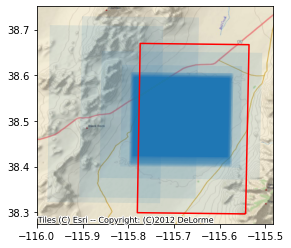

In [215]:
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list]
footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=BATCHNAME, DROP_DUPLICATES=True)
print('Plotting footprints in blue, and target footprint in red.')
target_footprint_gdf = footprint_gdf[footprint_gdf['file'].str.contains(SELECTED_DICT['target_catid'])] 
ax = footprint_gdf.plot(alpha=0.1)
ax = target_footprint_gdf.boundary.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs=4326, 
    #source = ctx.providers.Gaode.Satellite
    #source = ctx.providers.Esri.WorldShadedRelief
    #source = ctx.providers.Esri.WorldGrayCanvas
    #source = ctx.providers.Esri.NatGeoWorldMap
    #source = ctx.providers.Esri.WorldImagery
    source = ctx.providers.Esri.DeLorme
)

Choose a raster source for the bounds in which random points will be generated

In [202]:
fn_of_selected_catid = [i for i in SELECTED_DICT['f_list'] if SELECTED_DICT['target_catid'] in i][0]
src = rasterio.open(fn_of_selected_catid)
gdf_random_points, gdf_bounding_polygon = get_random_points_in_bounds(src, n_points=10)

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


# Map the target bounds and random points

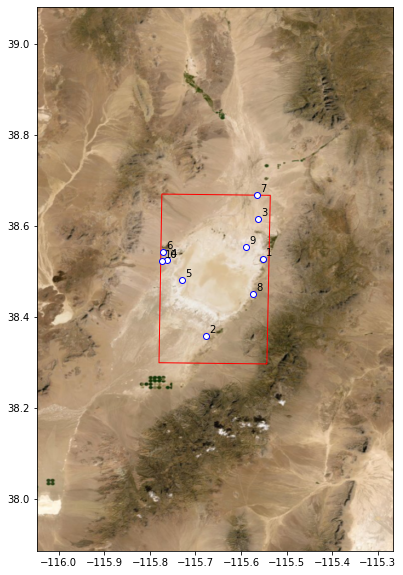

In [218]:
ax = gdf_bounding_polygon.to_crs(4326).plot(figsize=(10, 10), edgecolor='red', color='none')
ax = gdf_random_points.to_crs(4326).plot(ax=ax, edgecolor='blue', color='white')
for x, y, label in zip(gdf_random_points.lon, gdf_random_points.lat, gdf_random_points.site):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.margins(y=1.1, x=1.1)
#ctx.add_basemap(ax,  source='https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}', crs=4326)
ctx.add_basemap(ax, source='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', crs=4326)


In [204]:
gdf_random_points.head()

,points,lon,lat,geometry,site,crs
0,"(626213.1321232992, 4265295.326081073)",-115.552058,38.527112,POINT (626213.132 4265295.326),1,proj=utm zone=11 datum=WGS84 units=m no_defs e...
1,"(615621.4413021202, 4246404.6953162765)",-115.676649,38.358351,POINT (615621.441 4246404.695),2,proj=utm zone=11 datum=WGS84 units=m no_defs e...
2,"(625217.5557974054, 4275015.011229674)",-115.561731,38.614819,POINT (625217.556 4275015.011),3,proj=utm zone=11 datum=WGS84 units=m no_defs e...
3,"(607903.6316659254, 4264843.545752464)",-115.762129,38.525450,POINT (607903.632 4264843.546),4,proj=utm zone=11 datum=WGS84 units=m no_defs e...
4,"(610817.3249369415, 4259981.350360382)",-115.729481,38.481284,POINT (610817.325 4259981.350),5,proj=utm zone=11 datum=WGS84 units=m no_defs e...


In [205]:
m = maplib.MAP_LAYER_FOLIUM(LAYER=gdf_bounding_polygon.to_crs(3857), LAYER_COL_NAME='name', lat_start=gdf_bounding_polygon.to_crs(4326).geometry.centroid.y, lon_start=gdf_bounding_polygon.to_crs(4326).geometry.centroid.x)
maplib.ADD_POINT_OBS_TO_MAP(gdf_random_points.to_crs(3857) ,foliumMap=m)
#maplib.MAP_LAYER_FOLIUM(LAYER=gdf_random_points[["geometry", "site"]].to_crs(3857), LAYER_COL_NAME='site', foliumMap=m)

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



# Run the extraction function, return a time-series dataframe, plot

In [206]:
plotnine.options.figure_size = (18, 10)
# https://stackoverflow.com/questions/20571306/multi-row-x-axis-labels-in-ggplot-line-chart

In [209]:
df_sr = get_ref_timeseries_table(gdf_random_points, f_list, batchname=BATCHNAME, DO_4BAND = True)
df_sr['type_ref'] = 'SR'

['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']
['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']


In [208]:
df_toa = get_ref_timeseries_table(gdf_random_points, f_toa_list, batchname=BATCHNAME, DO_4BAND = True)
df_toa['type_ref'] = 'TOA'

['BAND_B', 'BAND_G', 'BAND_R', 'BAND_N']


#### Number of images from this time-series (max number differs for each random point being examined)

In [214]:
g = df_toa.dropna().groupby('name')
len(list(g.groups))

50

# Plot time-series

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


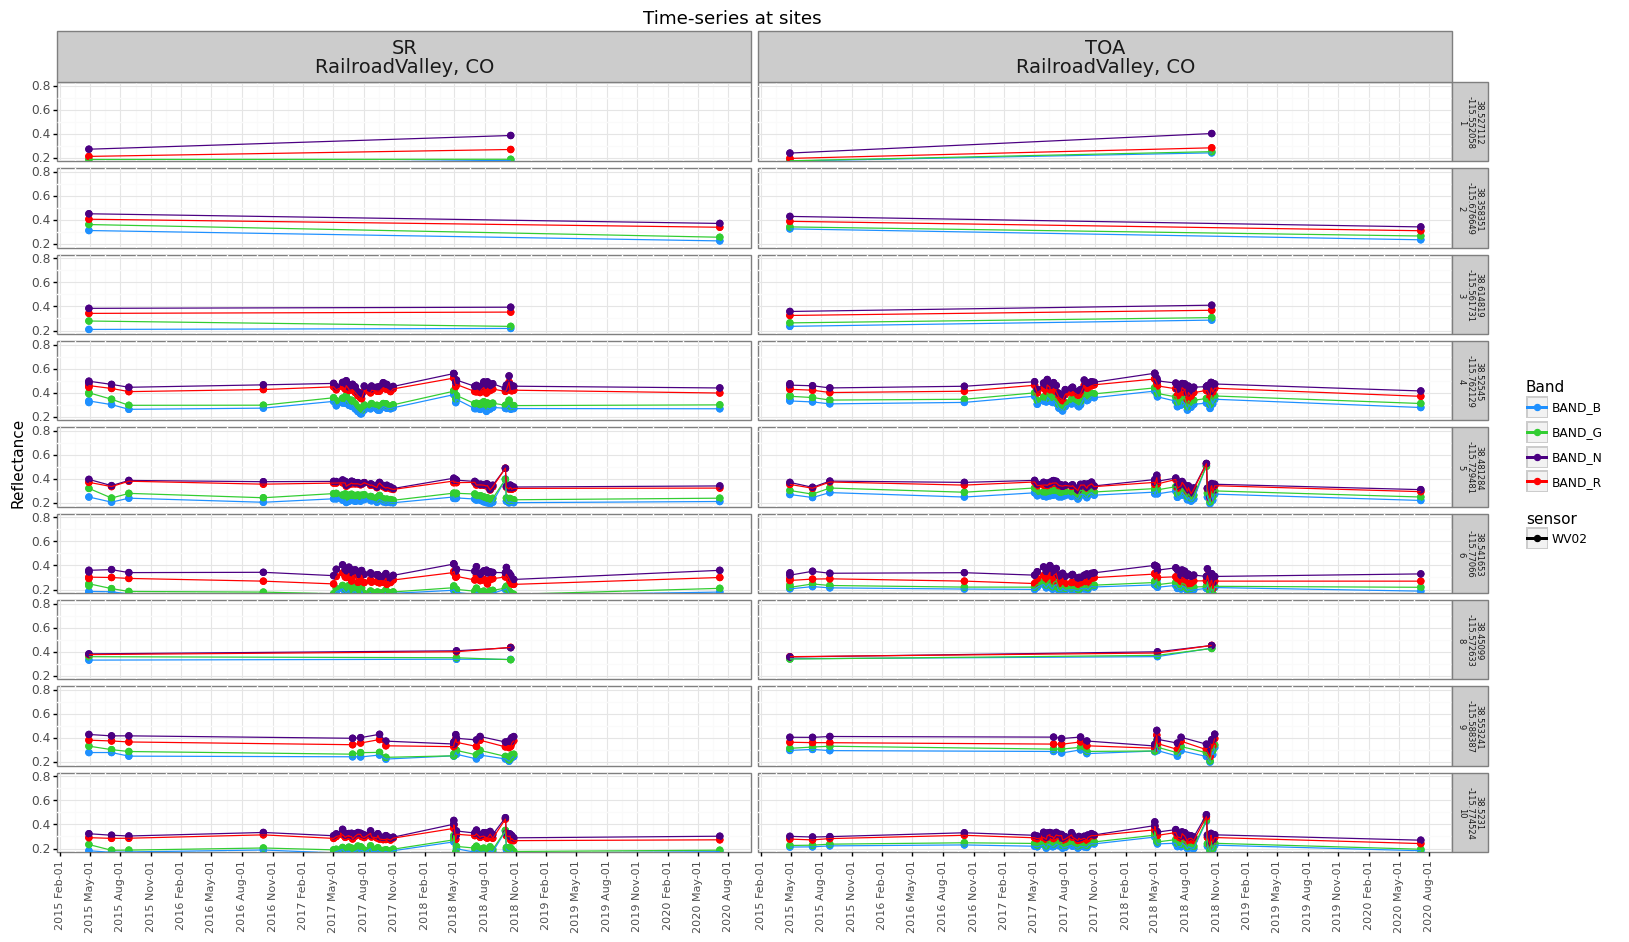

<ggplot: (2963452109709)>

In [213]:
plot_timeseries(pd.concat([df_sr,df_toa]), YLIMS = (0.20,0.8))